# Import libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from geopy.distance import great_circle
from pymongo import MongoClient
import calendar

import geopandas as gpd
from shapely.geometry import Point
import time
import random

# setup database

In [2]:
client = MongoClient('localhost', 27017)
db = client['promed']
posts = db.posts

# setup map

In [3]:
# Use shapefile bundled with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

projectHeatmap = True  # Color clusters by the amount of articles they contain
sizeX = 8
sizeY = 5
markerSize = 5

# Functions

In [4]:
# Gets a unique list of diseases
def get_disease_list():
#   diseaseNames = posts.distinct('subject.diseaseLabels')
#   return sorted(diseaseNames)
    return ['Anthrax']

In [5]:
# Get all the articles that have the current disease in it's "diseaseLabels" array
def get_articles(disease):
#   print('get articles', disease)
  articles = posts.find({ 
    'zoomLat': {'$ne': None}, 
    'zoomLon': {'$ne': None}, 
    'subject.diseaseLabels':{'$not':{'$size': 0}}, 
    'subject.diseaseLabels': {'$in': [disease]}
    },
    {'subject.diseaseLabels':1,
    'zoomLat': 1, 
    'zoomLon': 1, 
    'sourceDate': 1, 
    'promedDate': 1}
  ).limit(300)
  articles = list(articles);
  for article in articles:
    try:
        # not all articles have a sourceDate so fall back to promedDate if missing.
        date = article.get('sourceDate') or article.get('promedDate')
        # convert date object to timestamp so DBSCAN can handle it
        article['sourceDate'] = calendar.timegm(date.timetuple())/10000000.0
        # convert disease labels array to single disease name
        article['subject'] = article['subject']['diseaseLabels'][0]
        article['zoomLat'] = float(article['zoomLat'])
        article['zoomLon'] = float(article['zoomLon'])
    except Exception as e:
        print("Problem parsing article:", article)
        print(e)
        raise
#   print(sorted([x['sourceDate'] for x in articles]))

  return articles

### Mapping Functions

In [6]:
def get_points_projection(df):
    # create a new geopandas geodataframe from the point data
    points = gpd.GeoDataFrame(df)
     # create a geometry column in our point data set for geopandas to use
    points['geometry'] = points.apply(lambda item: Point(item['zoomLon'], item['zoomLat']), axis=1)
    points.crs = world.crs
    return points


# Available color maps: http://matplotlib.org/users/colormaps.html
def project_map(pointList):
    fig, ax = plt.subplots()
    fig.set_size_inches(sizeX, sizeY)
    ax.set_aspect('equal')
    world.plot(ax=ax, color='white', edgecolor='#cccccc')
    
#     Sort by length of cluster
    pointList.sort(lambda x,y: cmp(len(x), len(y)))
    
    if projectHeatmap:
        cmap = cm.get_cmap('plasma')
        for points in pointList:
            color = cmap(len(points)/float(7))
            points.plot(ax=ax, marker='o', color=color, markersize=markerSize)
#         Add colorbar
        vmin, vmax = 1, 7
        fig = ax.get_figure()
        cax = fig.add_axes([1, 0.21, 0.03, 0.61])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        cbar = fig.colorbar(sm, cax=cax, ticks=[1, 3, 5, 7])
        
    else:
        cmap = cm.get_cmap('gist_ncar')
        for points in pointList:
            color = cmap(random.random())
            points.plot(ax=ax, marker='o', color=color, markersize=markerSize)
        
    plt.show()

# Single step clustering on timestamp/lat/long

### Questions:
How do I determine the optimal `eps` value here?

How should I take into account the third dimension (timestamp) when determining the `eps` value?  When it was only lat long the values were in similar ranges (-90 -> 90 and -180 -> 180) but with the timestamp values are much larger (ex: `9433152000`) which makes me thing that you will never get two timestamps in the same neighborhood if you have and eps value of, say, 2.  If I begin dividing the timestamp value by 10,000,000 it goes into a similar range for lat/long - is this something I should consider doing?

Is it possible to specify dimensions for a sphereoid to define the `eps`?  It seems like there are a lot of situations where you wouldn't want a perfectly simetrical shape defining the neighborhood.

How would I go about visualizing 3d data?  4d?


In [7]:
def cluster(data, fields, eps=2):
#     print(type(data))
    if type(data) is not np.ndarray:
#         print('convert....')
        data = data.as_matrix(columns=fields)
#     print(type(data))
    #   coordinates = df.as_matrix(columns=['zoomLon', 'zoomLat'])
    dbsc = DBSCAN(eps=eps, min_samples=1, algorithm='ball_tree').fit(data)
    core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
    core_samples_mask[dbsc.core_sample_indices_] = True
    cluster_labels = dbsc.labels_
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    clusters = pd.Series([data[cluster_labels == n] for n in range(num_clusters)])
#     print('Number of clusters: {}'.format(num_clusters))
#     for cluster in clusters:
#         print(cluster[:])
#     print('***********')
    return clusters

In [8]:
def distance_cluster(data, fields):
    kms_per_radian = 6371.0088
    eps = 1000 / kms_per_radian
#     print("distance data:")
#     print(np.radians(data[fields]))
    dbsc = DBSCAN(eps=eps, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(data[fields]))
    core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
    core_samples_mask[dbsc.core_sample_indices_] = True
    cluster_labels = dbsc.labels_
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    clusters = pd.Series([data[cluster_labels == n] for n in range(num_clusters)])
    return clusters

In [9]:
def cluster_single_step(df):
    cluster(df,['zoomLon', 'zoomLat', 'sourceDate'])

# Two step temporal/spatial clustering
First cluster on times only.  After that cluster on lat/long great circle distances

In [10]:
def cluster_two_step(df):
    # perform temporal clustering
    temporalClusters = cluster(df,['sourceDate'], .1) # eps of .1 ~ 8 days

    allClusterPoints = []
    for temporalCluster in temporalClusters:
        subSet = df['sourceDate'].isin(temporalCluster.flatten())
        clusterArticles = df.loc[subSet][['sourceDate','zoomLat','zoomLon']]

#         perform clustering on the articles in that cluster based on the lat/long great circle distance
        spacialTemporalClusters = distance_cluster(clusterArticles, ['zoomLat', 'zoomLon'])

#         record point data for the cluster
        pointList = []
        for spacialCluster in spacialTemporalClusters:
            clusterPoints = get_points_projection(spacialCluster)
            pointList.append(clusterPoints)
            allClusterPoints.append(clusterPoints)
        
#         Project to map and print columns
        project_map(pointList)
        for spacialCluster in spacialTemporalClusters:
            print(spacialCluster[['sourceDate','zoomLat','zoomLon']])

#     Project all layers into a map. Warning: heavy.
    print('\n\n')
    print("--------------------------------------------------------------------------------")
    print("--- All recorded points --------------------------------------------------------")
    print("--------------------------------------------------------------------------------")
    project_map(allClusterPoints)

# Process articles

--------------------------------------------------------------------------------
300 articles for Anthrax


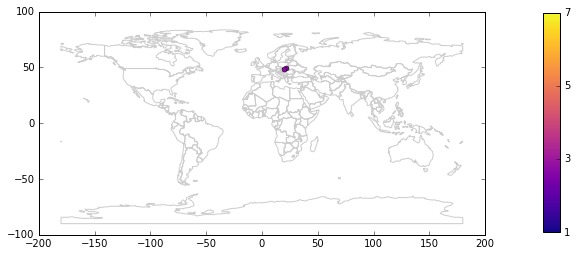

   sourceDate    zoomLat    zoomLon
0   135.27648  49.202110  21.652161
1   135.27648  48.707531  19.491650


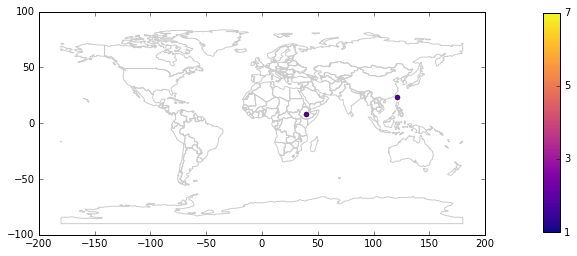

   sourceDate  zoomLat    zoomLon
2   94.408869  8.62622  39.616032
   sourceDate    zoomLat     zoomLon
3   94.400886  23.873001  121.016998


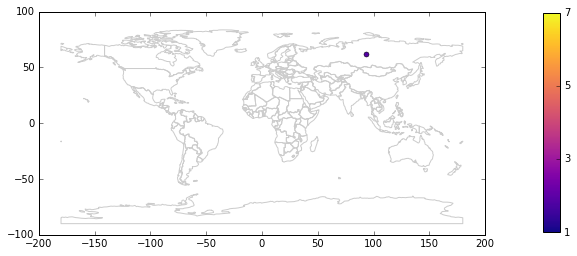

   sourceDate   zoomLat   zoomLon
4    80.78305  61.94614  93.57769


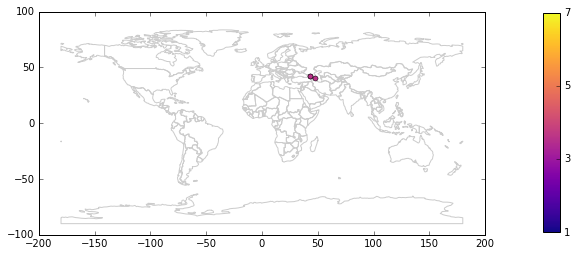

   sourceDate    zoomLat    zoomLon
5   81.439487  41.926311  43.517448
8   81.449220  41.926311  43.517448
9   81.482903  40.500000  47.500000


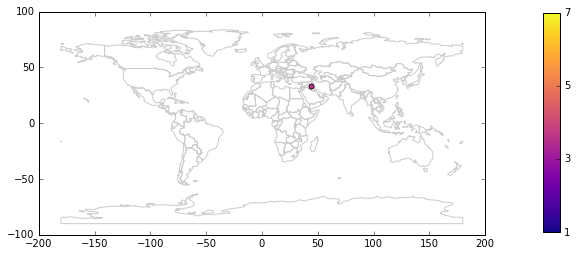

    sourceDate    zoomLat    zoomLon
6    80.913600  33.048031  43.772129
7    80.982234  33.048031  43.772129
11   80.904960  33.048031  43.772129


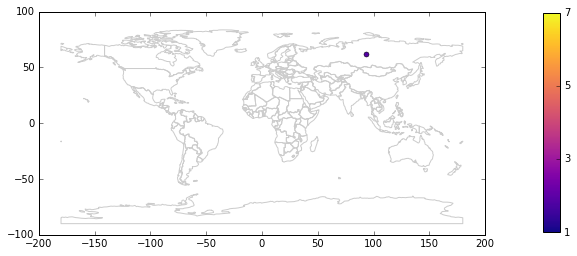

    sourceDate   zoomLat   zoomLon
10   83.710131  61.94614  93.57769


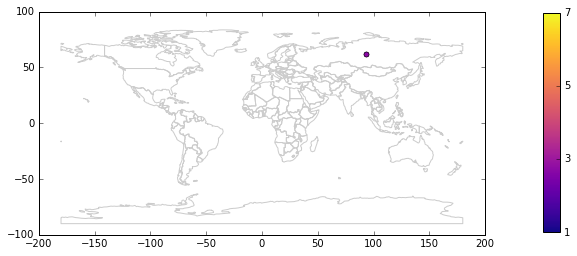

    sourceDate   zoomLat   zoomLon
12   84.651085  61.94614  93.57769
13   84.671940  61.94614  93.57769


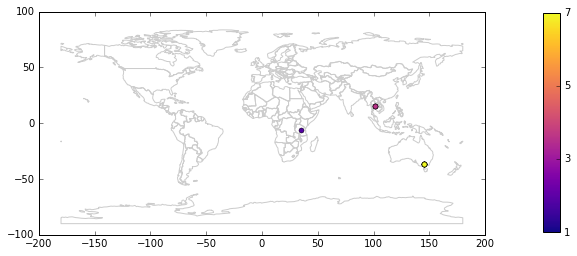

    sourceDate   zoomLat     zoomLon
14   85.559674  15.12704  101.017357
15   85.568007  15.12704  101.017357
18   85.585403  15.12704  101.017357
    sourceDate  zoomLat     zoomLon
16   85.566806 -36.9851  145.019501
17   85.575793 -36.9851  145.019501
19   85.594196 -36.9851  145.019501
20   85.570560 -36.9851  145.019501
21   85.602003 -36.9851  145.019501
22   85.626301 -36.9851  145.019501
23   85.658570 -36.9851  145.019501
24   85.717380 -36.9851  145.019501
    sourceDate  zoomLat  zoomLon
92    85.78656     -6.0     35.0


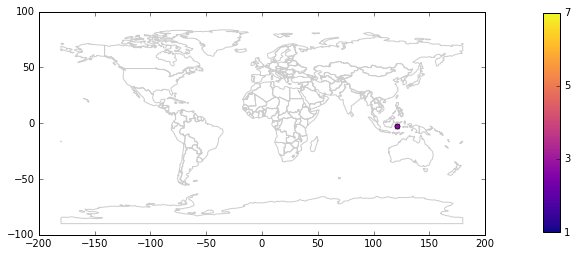

    sourceDate  zoomLat   zoomLon
25     83.8857  -2.6358  120.9375
26     83.9289  -2.6358  120.9375


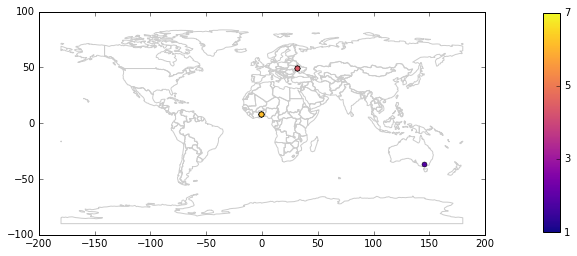

    sourceDate  zoomLat  zoomLon
27   86.417220  7.95985  -1.2073
28   86.421172  7.95985  -1.2073
29   86.425920  7.95985  -1.2073
32   86.451780  7.95985  -1.2073
33   86.451780  7.95985  -1.2073
37   86.546880  7.95985  -1.2073
    sourceDate   zoomLat   zoomLon
30   86.437395  49.01709  31.38711
31   86.434560  49.01709  31.38711
35   86.449035  49.01709  31.38711
36   86.512320  49.01709  31.38711
    sourceDate  zoomLat     zoomLon
38    86.53818 -36.9851  145.019501


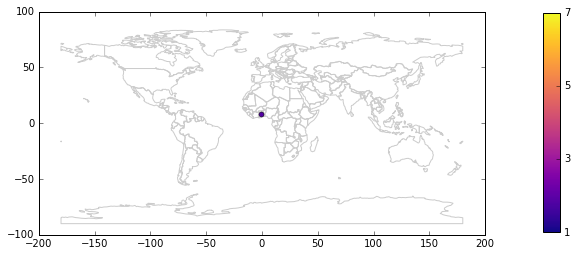

    sourceDate  zoomLat  zoomLon
34    86.19264  7.95985  -1.2073


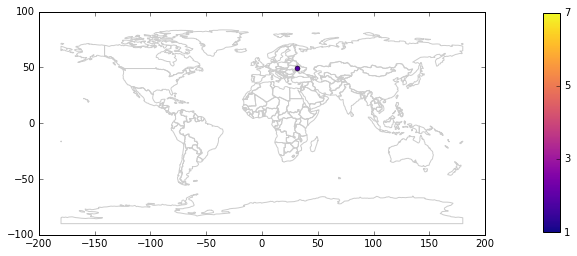

    sourceDate   zoomLat   zoomLon
39     86.7024  49.01709  31.38711


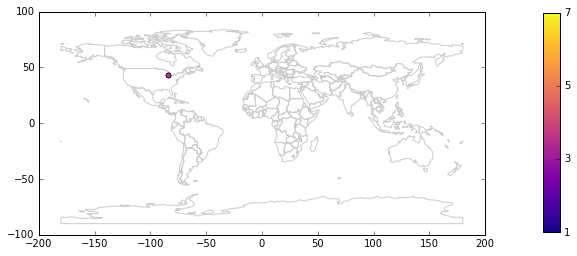

    sourceDate    zoomLat    zoomLon
40   86.948815  43.580299 -84.462898
42   86.959009  43.580299 -84.462898
45   86.961510  43.580299 -84.462898


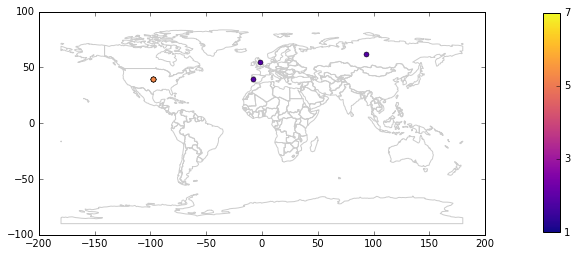

    sourceDate   zoomLat   zoomLon
41   89.129017  61.94614  93.57769
    sourceDate    zoomLat  zoomLon
43   89.172677  54.470001  -2.0215
    sourceDate   zoomLat  zoomLon
44   89.133843  39.60099 -8.06274
    sourceDate   zoomLat    zoomLon
91   89.094327  39.96693 -97.556099
95   89.186706  39.96693 -97.556099
97   89.218191  39.96693 -97.556099
98   89.265438  39.96693 -97.556099
99   89.269752  39.96693 -97.556099


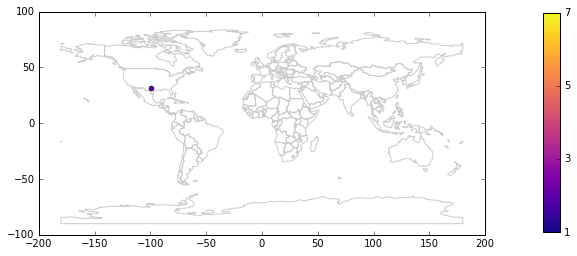

    sourceDate  zoomLat  zoomLon
46   87.072725  31.2409 -99.2286


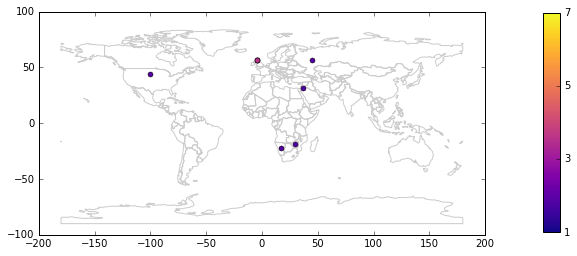

    sourceDate    zoomLat     zoomLon
47    87.20352  44.496498 -100.239304
    sourceDate    zoomLat    zoomLon
48    87.20352  56.824932  44.648438
    sourceDate  zoomLat  zoomLon
49   87.260759     56.5     -4.0
51   87.203520     56.5     -4.0
53   87.341760     56.5     -4.0
    sourceDate    zoomLat   zoomLon
50    87.20352 -19.000099  29.87184
    sourceDate    zoomLat    zoomLon
52     87.2208  31.253321  36.786732
    sourceDate    zoomLat    zoomLon
57   87.302315 -22.133249  17.218281


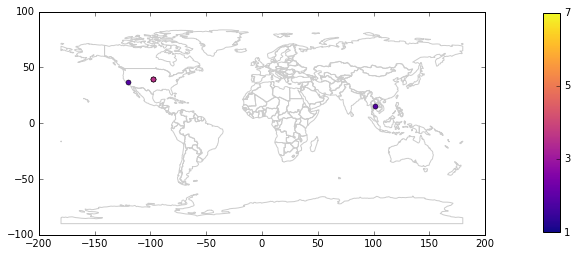

     sourceDate   zoomLat    zoomLon
54    89.587915  39.96693 -97.556099
102   89.433489  39.96693 -97.556099
103   89.559283  39.96693 -97.556099
     sourceDate    zoomLat     zoomLon
100   89.399032  37.250198 -119.750298
     sourceDate   zoomLat     zoomLon
101    89.48906  15.12704  101.017357


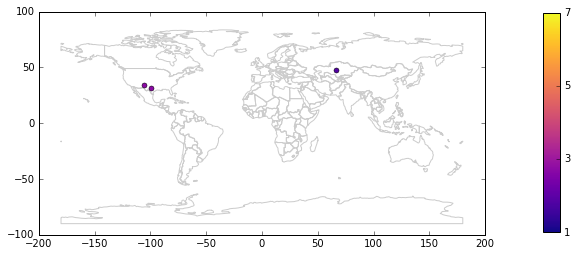

    sourceDate    zoomLat    zoomLon
55   87.461138  48.015991  66.657822
    sourceDate  zoomLat     zoomLon
56   87.468029  31.2409  -99.228600
59   87.462720  34.4884 -105.996101


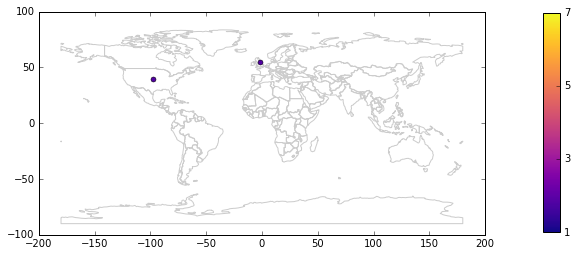

    sourceDate   zoomLat    zoomLon
58   89.709469  39.96693 -97.556099
     sourceDate    zoomLat  zoomLon
104   89.731974  54.470001  -2.0215


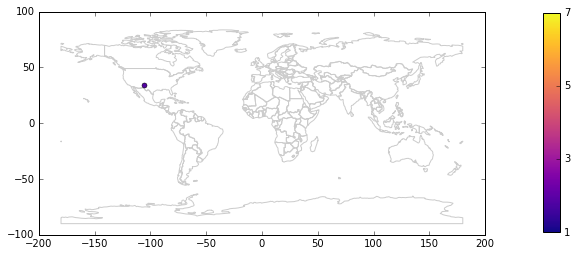

    sourceDate  zoomLat     zoomLon
60    87.65274  34.4884 -105.996101


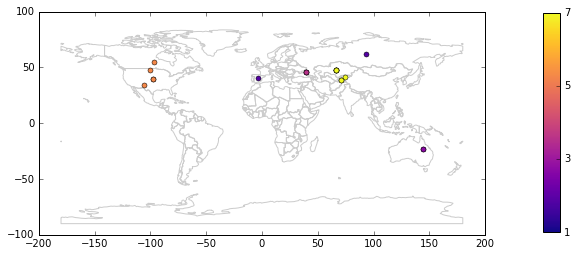

    sourceDate    zoomLat     zoomLon
61   89.993856  39.966930  -97.556099
69   90.154995  47.487499 -100.019600
74   90.226640  55.002800  -96.987396
94   90.357589  39.966930  -97.556099
96   90.353312  34.488400 -105.996101
    sourceDate    zoomLat    zoomLon
63   90.054660  48.015991  66.657822
65   90.120482  48.015991  66.657822
66   90.120858  48.015991  66.657822
67   90.129585  48.015991  66.657822
78   90.235523  41.465050  74.555603
80   90.235694  38.528179  71.042000
81   90.232842  38.528179  71.042000
93   90.338572  48.015991  66.657822
    sourceDate   zoomLat   zoomLon
64   90.109768  61.94614  93.57769
    sourceDate  zoomLat    zoomLon
70   90.155042  45.6908  39.830898
71   90.155276  45.6908  39.830898
79   90.233480  45.6908  39.830898
    sourceDate   zoomLat  zoomLon
73   90.208672  40.22683 -3.64957
    sourceDate  zoomLat     zoomLon
85   90.240994 -23.3221  143.964798
88   90.250131 -23.3221  143.964798


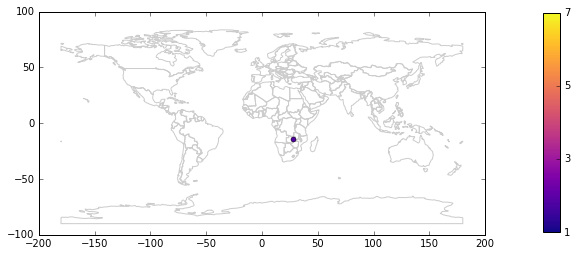

    sourceDate   zoomLat   zoomLon
62    88.08575 -13.95302  27.79825


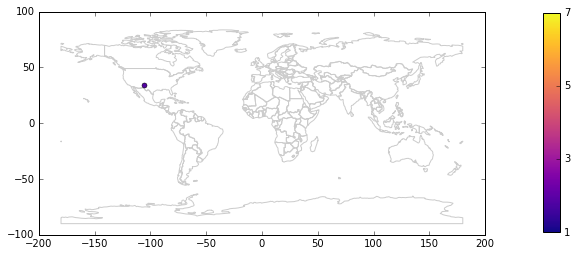

    sourceDate  zoomLat     zoomLon
68   88.274493  34.4884 -105.996101


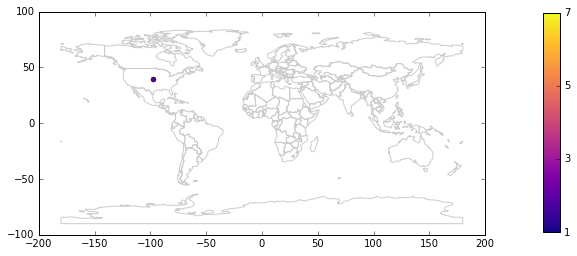

    sourceDate   zoomLat    zoomLon
72   88.377304  39.96693 -97.556099


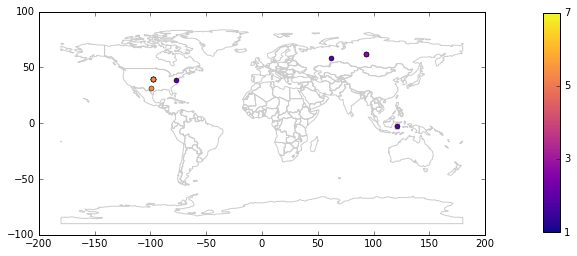

    sourceDate   zoomLat   zoomLon
75   88.758422  61.94614  93.57769
76   88.811169  61.94614  93.57769
    sourceDate   zoomLat    zoomLon
77   88.793073  39.96693 -97.556099
83   88.858141  39.96693 -97.556099
84   88.903620  39.96693 -97.556099
87   88.947708  31.24090 -99.228600
90   88.819121  39.96693 -97.556099
    sourceDate    zoomLat    zoomLon
82   88.661621  57.984798  61.962799
    sourceDate  zoomLat    zoomLon
86   88.948151   38.895 -77.036697
    sourceDate  zoomLat   zoomLon
89    88.97472  -2.6358  120.9375


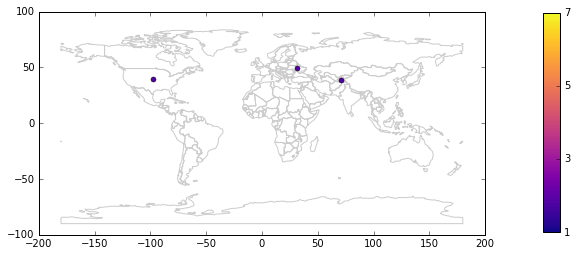

     sourceDate   zoomLat   zoomLon
105    90.53538  49.01709  31.38711
     sourceDate   zoomLat    zoomLon
106   90.553374  39.96693 -97.556099
     sourceDate    zoomLat  zoomLon
107   90.616836  38.528179   71.042


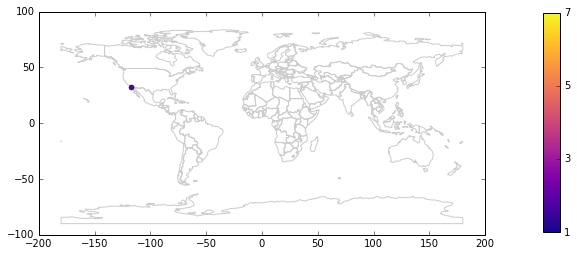

     sourceDate    zoomLat     zoomLon
108    90.72858  32.713299 -117.158302


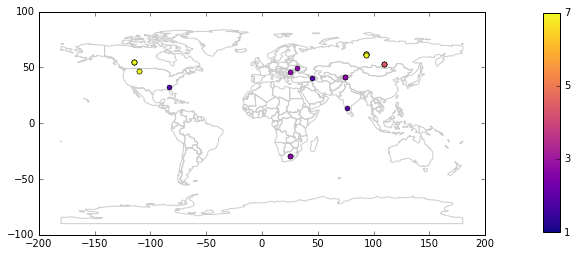

     sourceDate    zoomLat     zoomLon
109   92.777143  47.010201 -109.731499
119   92.776320  47.010201 -109.731499
135   93.456225  55.153702 -115.004898
136   93.620080  55.153702 -115.004898
157   93.191040  55.153702 -115.004898
159   93.352787  55.153702 -115.004898
160   93.382038  55.153702 -115.004898
     sourceDate    zoomLat    zoomLon
111   92.977459  45.843609  24.969259
131   93.243981  49.017090  31.387110
     sourceDate    zoomLat     zoomLon
113   93.196936  53.014702  108.984299
114   93.240248  53.014702  108.984299
128   93.182645  53.014702  108.984299
156   93.176502  53.014702  108.984299
     sourceDate    zoomLat    zoomLon
115   93.270692 -28.998529  25.092541
116   93.314459 -28.998529  25.092541
     sourceDate   zoomLat    zoomLon
120   93.370443  41.46505  74.555603
158   93.268800  41.46505  74.555603
     sourceDate   zoomLat    zoomLon
122   93.481551  61.17070  92.988197
123   92.913060  61.94614  93.577690
127   93.085630  61.94614  93.577690
137   

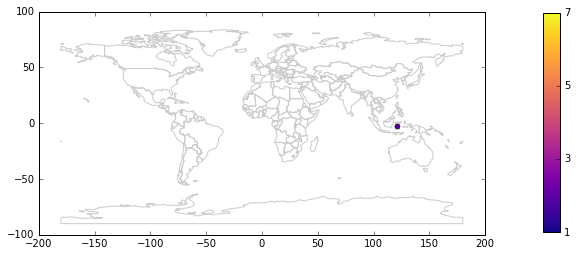

     sourceDate  zoomLat   zoomLon
110     92.1024  -2.6358  120.9375


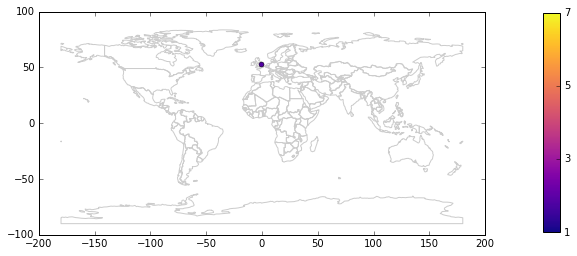

     sourceDate    zoomLat  zoomLon
112    90.84861  53.034599  -0.5604


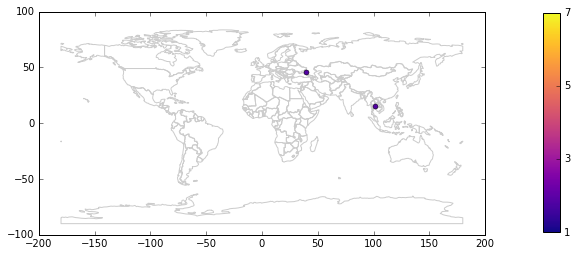

     sourceDate  zoomLat    zoomLon
117    92.24924  45.6908  39.830898
     sourceDate   zoomLat     zoomLon
118    92.26656  15.12704  101.017357


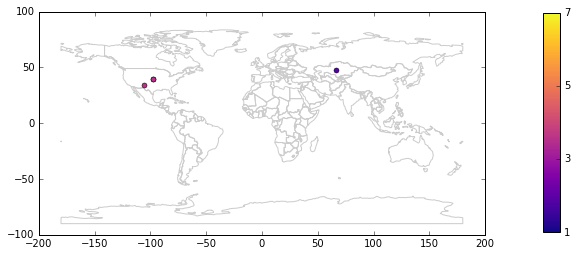

     sourceDate    zoomLat    zoomLon
121    90.95322  48.015991  66.657822
     sourceDate   zoomLat     zoomLon
124   90.979808  39.96693  -97.556099
125   90.985424  34.48840 -105.996101
126   91.004455  39.96693  -97.556099


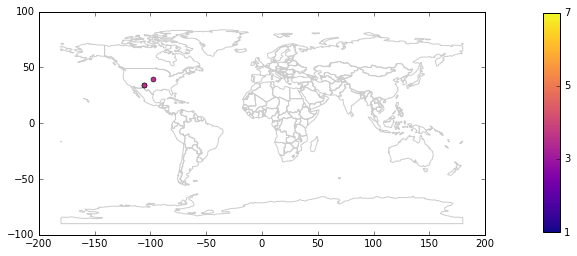

     sourceDate   zoomLat     zoomLon
129   91.106300  34.48840 -105.996101
132   91.122372  34.48840 -105.996101
134   91.160156  39.96693  -97.556099


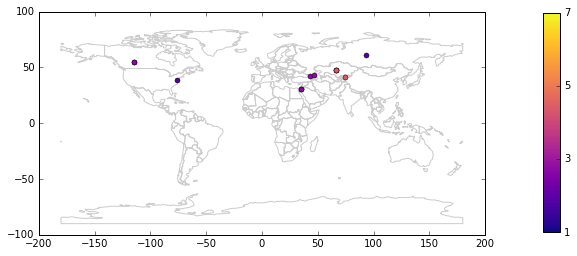

     sourceDate    zoomLat    zoomLon
130   93.802587  48.015991  66.657822
149   93.960000  48.015991  66.657822
168   93.726720  41.465050  74.555603
169   93.809474  48.015991  66.657822
     sourceDate    zoomLat    zoomLon
139   93.749698  41.926311  43.517448
151   94.004975  43.000000  47.000000
     sourceDate  zoomLat    zoomLon
140    93.75264  61.1707  92.988197
     sourceDate  zoomLat    zoomLon
141   93.844341   30.921  34.865101
173   93.983509   30.921  34.865101
     sourceDate  zoomLat    zoomLon
153   94.022596  38.9594 -76.376999
     sourceDate    zoomLat     zoomLon
170   93.880563  55.153702 -115.004898
171   93.907792  55.153702 -115.004898


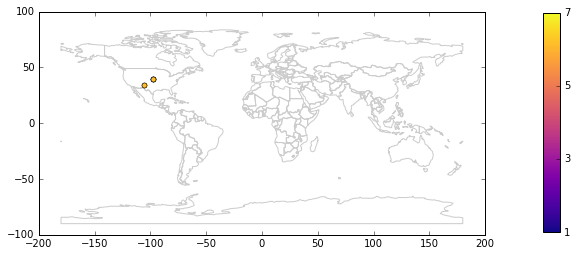

     sourceDate   zoomLat     zoomLon
142   91.486760  39.96693  -97.556099
143   91.488136  34.48840 -105.996101
144   91.493418  39.96693  -97.556099
145   91.505826  39.96693  -97.556099
146   91.505766  34.48840 -105.996101
148   91.502046  39.96693  -97.556099


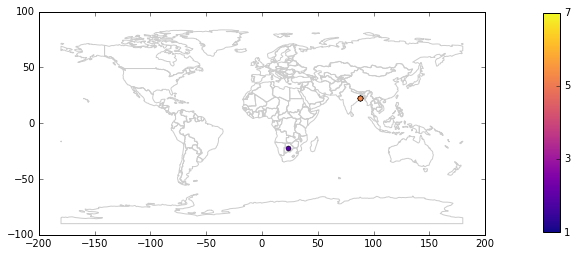

     sourceDate  zoomLat    zoomLon
155   95.230271    22.82  88.199997
163   95.122080    22.82  88.199997
164   95.160960    22.82  88.199997
165   95.135040    22.82  88.199997
166   95.221440    22.82  88.199997
     sourceDate    zoomLat    zoomLon
167    95.23872 -22.181999  23.815029


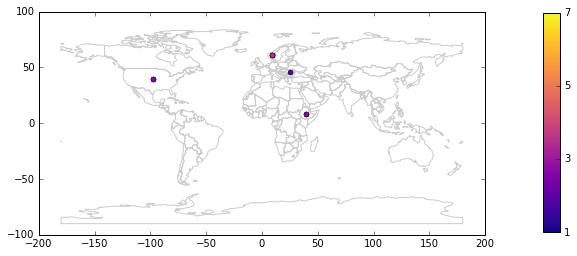

     sourceDate   zoomLat    zoomLon
172   95.697619  39.96693 -97.556099
174   95.705280  39.96693 -97.556099
     sourceDate    zoomLat    zoomLon
175    95.74848  45.843609  24.969259
     sourceDate    zoomLat  zoomLon
176    95.75712  60.716099   8.7451
177    95.78304  60.716099   8.7451
178    95.81760  60.716099   8.7451
     sourceDate  zoomLat    zoomLon
179   95.808960  8.62622  39.616032
181   95.864318  8.62622  39.616032


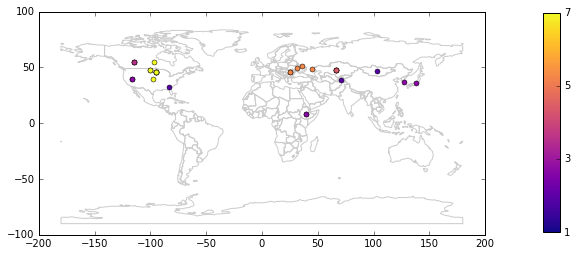

     sourceDate    zoomLat    zoomLon
180   96.599482  48.015991  66.657822
186   96.784240  48.015991  66.657822
207   96.318720  48.015991  66.657822
260   96.940800  48.015991  66.657822
     sourceDate    zoomLat     zoomLon
182   96.698730  39.966930  -97.556099
183   96.705058  46.225399  -94.658302
185   96.771192  47.487499 -100.019600
189   96.896532  46.225399  -94.658302
223   96.523574  47.487499 -100.019600
227   96.533806  46.225399  -94.658302
237   96.673272  55.002800  -96.987396
247   96.750720  46.225399  -94.658302
255   96.862980  46.225399  -94.658302
     sourceDate    zoomLat     zoomLon
184   96.765066  46.835289  103.083221
     sourceDate    zoomLat     zoomLon
208   96.318720  36.615501  127.726997
214   96.383876  36.098541  138.478607
     sourceDate  zoomLat    zoomLon
211   96.370560  8.62622  39.616032
216   96.410831  8.62622  39.616032
     sourceDate    zoomLat     zoomLon
215   96.403566  55.153702 -115.004898
222   96.459438  55.153702 -115.004898


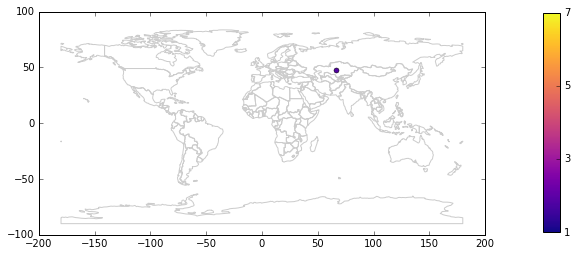

     sourceDate    zoomLat    zoomLon
187    97.18272  48.015991  66.657822


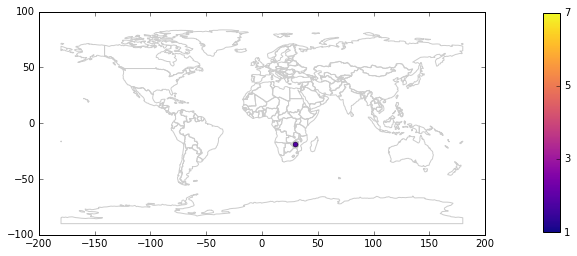

     sourceDate    zoomLat   zoomLon
188  154.516254 -19.000099  29.87184


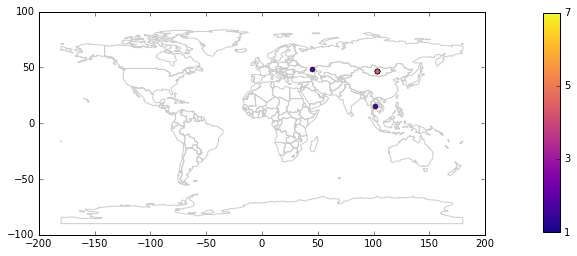

     sourceDate    zoomLat  zoomLon
190     95.9904  48.716301  44.5145
     sourceDate    zoomLat     zoomLon
191   95.999040  46.835289  103.083221
193   96.068160  46.835289  103.083221
194   96.085440  46.835289  103.083221
199   96.121585  46.835289  103.083221
     sourceDate   zoomLat     zoomLon
202   96.198915  15.12704  101.017357


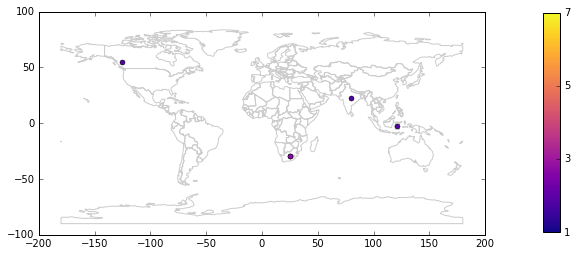

     sourceDate    zoomLat    zoomLon
192   98.150400 -28.998529  25.092541
197   98.215696 -28.998529  25.092541
     sourceDate  zoomLat   zoomLon
198    98.26272  -2.6358  120.9375
     sourceDate   zoomLat    zoomLon
201   98.085091  22.88348  79.616203
     sourceDate    zoomLat   zoomLon
212   98.078748  54.673801 -124.9366


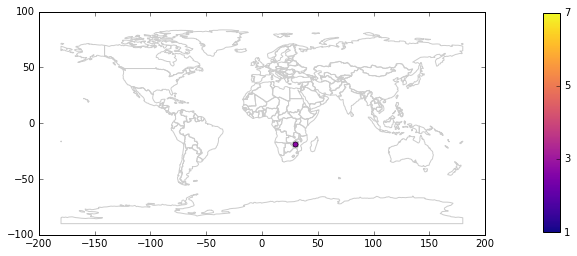

     sourceDate    zoomLat   zoomLon
195   97.697808 -19.000099  29.87184
206   97.735680 -19.000099  29.87184


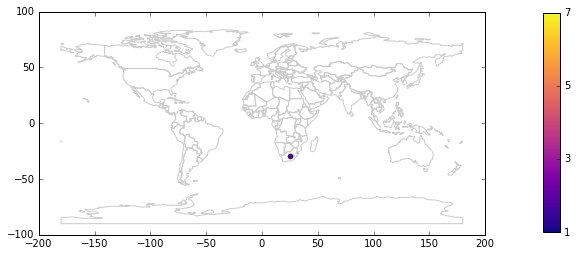

     sourceDate    zoomLat    zoomLon
196    95.00544 -28.998529  25.092541


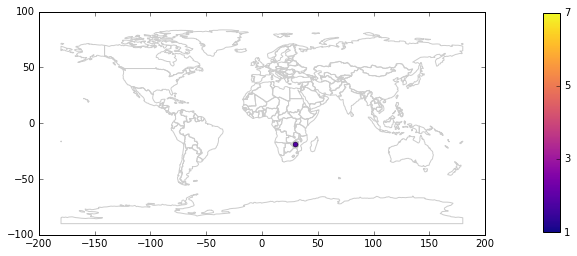

     sourceDate    zoomLat   zoomLon
200     97.9776 -19.000099  29.87184


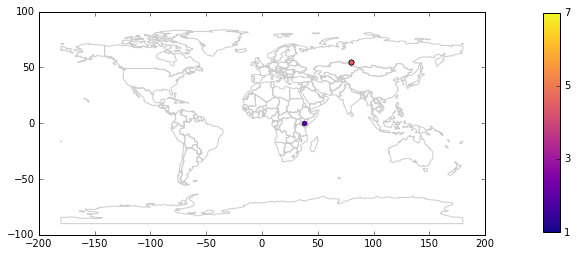

     sourceDate  zoomLat    zoomLon
203   98.483400  55.2271  80.068298
204   98.506542  55.2271  80.068298
205   98.531814  55.2271  80.068298
213   98.599680  55.2271  80.068298
     sourceDate  zoomLat   zoomLon
210    98.53056  0.52986  37.85788


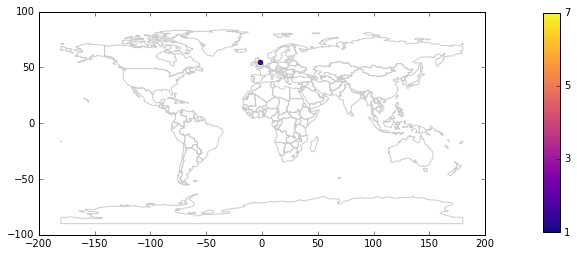

     sourceDate    zoomLat  zoomLon
209   98.829738  54.470001  -2.0215


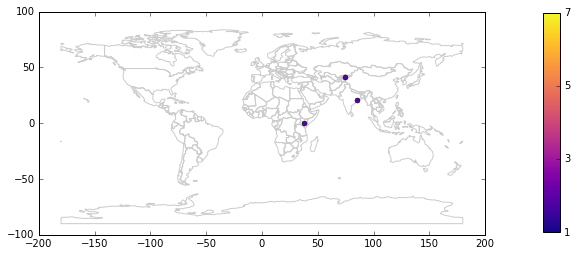

     sourceDate   zoomLat    zoomLon
219    99.13536  41.46505  74.555603
     sourceDate    zoomLat    zoomLon
226    99.12672  20.752399  85.001404
     sourceDate  zoomLat   zoomLon
257     99.1872  0.52986  37.85788


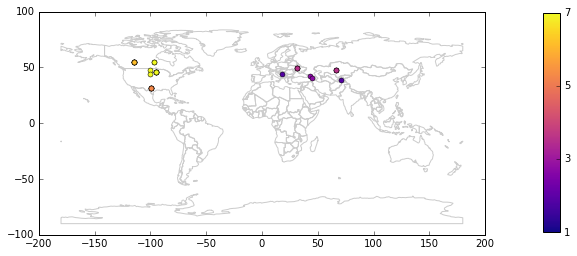

     sourceDate    zoomLat    zoomLon
220   99.325440  48.015991  66.657822
233   99.499242  48.015991  66.657822
252   99.720037  48.015991  66.657822
     sourceDate    zoomLat     zoomLon
224   99.394560  46.225399  -94.658302
229   99.434190  46.225399  -94.658302
231   99.472260  46.225399  -94.658302
240   99.657156  55.002800  -96.987396
243   99.662400  46.225399  -94.658302
249   99.518376  46.225399  -94.658302
259   99.619200  55.002800  -96.987396
270   99.804864  47.487499 -100.019600
288   99.924498  44.496498 -100.239304
     sourceDate  zoomLat  zoomLon
225   99.411840  31.2409 -99.2286
232   99.486381  31.2409 -99.2286
234   99.308160  31.2409 -99.2286
244   99.454980  31.2409 -99.2286
248   99.520482  31.2409 -99.2286
     sourceDate    zoomLat  zoomLon
228    99.42912  38.528179   71.042
     sourceDate    zoomLat     zoomLon
230   99.436464  55.153702 -115.004898
241   99.403200  55.153702 -115.004898
246   99.503352  55.153702 -115.004898
253   99.553092  55.153702

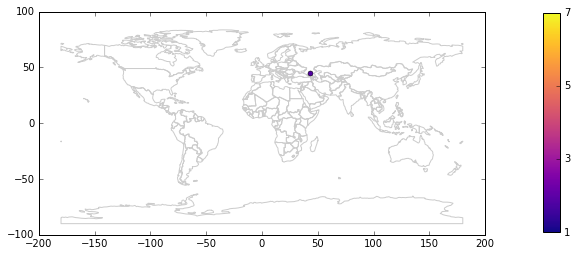

     sourceDate    zoomLat    zoomLon
242    98.93183  45.181999  43.275101


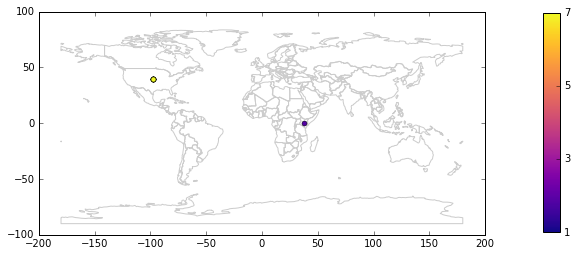

     sourceDate   zoomLat    zoomLon
264  100.747152  39.96693 -97.556099
265  100.768320  39.96693 -97.556099
266  100.846080  39.96693 -97.556099
268  100.448640  39.96693 -97.556099
269  100.474560  39.96693 -97.556099
271  100.500480  39.96693 -97.556099
281  100.647360  39.96693 -97.556099
285  100.716116  39.96693 -97.556099
     sourceDate  zoomLat   zoomLon
277   100.58862  0.52986  37.85788


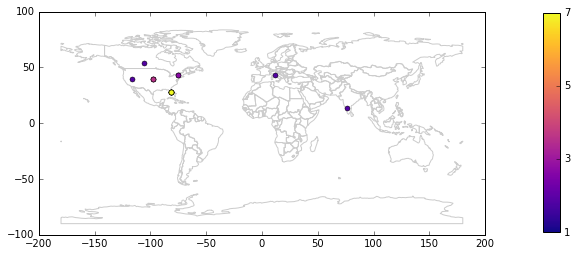

     sourceDate  zoomLat    zoomLon
272   100.21536  28.1495 -81.650398
274   100.21536  28.1495 -81.650398
275   100.21536  28.1495 -81.650398
278   100.24992  28.1495 -81.650398
279   100.24992  28.1495 -81.650398
283   100.26720  28.1495 -81.650398
284   100.27584  28.1495 -81.650398
     sourceDate    zoomLat     zoomLon
280  100.254262  54.007702 -105.996101
     sourceDate    zoomLat  zoomLon
287   100.28448  43.004601 -75.4981
290   100.28448  43.004601 -75.4981
     sourceDate    zoomLat     zoomLon
289  100.291362  39.266201 -116.762703
     sourceDate  zoomLat  zoomLon
291   100.29312     13.5     76.0
     sourceDate   zoomLat    zoomLon
292   100.29312  39.96693 -97.556099
295   100.31904  39.96693 -97.556099
298   100.33632  39.96693 -97.556099
     sourceDate   zoomLat   zoomLon
293  100.309512  42.79578  12.07174


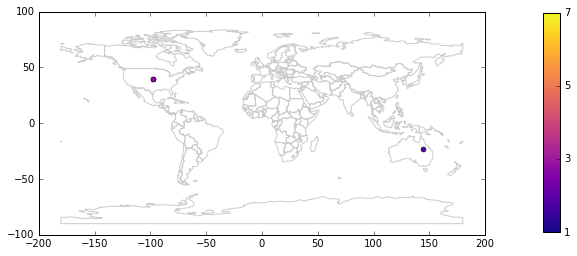

     sourceDate  zoomLat     zoomLon
273  101.071782 -23.3221  143.964798
     sourceDate   zoomLat    zoomLon
276  101.137358  39.96693 -97.556099
282  101.234880  39.96693 -97.556099


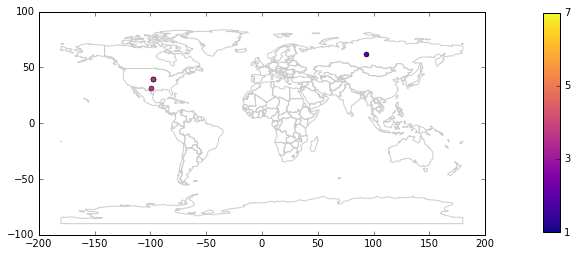

     sourceDate   zoomLat   zoomLon
294  101.436522  61.94614  93.57769
     sourceDate   zoomLat    zoomLon
296  101.474688  39.96693 -97.556099
297  101.494080  31.24090 -99.228600
299  101.555496  39.96693 -97.556099



--------------------------------------------------------------------------------
--- All recorded points --------------------------------------------------------
--------------------------------------------------------------------------------


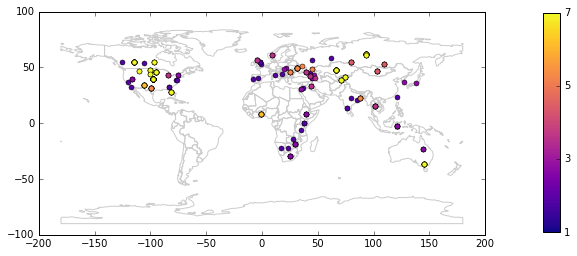

--- FINISHED -------------------------------------------------------------------
Total run time: 53.6s


In [11]:
diseaseList = get_disease_list()
# for each disease get a list of articles and cluster them
df = []
startTime = time.time()
for disease in diseaseList:
    articleList = list(get_articles(disease))
    print("--------------------------------------------------------------------------------")
    print("{0} articles for {1}".format(len(articleList), disease))
    df = pd.DataFrame(articleList)
#     cluster_single_step(df)
    cluster_two_step(df)

print("--- FINISHED -------------------------------------------------------------------")
print("Total run time: {0:.1f}s".format(time.time() - startTime))

# Questions:
What would be the next steps?  How do we determine which cluster future articles fall into?  Do I just re-run this with all the data?